<a href="https://www.kaggle.com/code/clemwo/delhi-s-climate-eda-statistical-testing?scriptVersionId=196261244" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
IMPORT_ADDITIONAL = True
if IMPORT_ADDITIONAL:
    !pip install scikit-posthocs
    !pip install pymannkendall

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)           

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import seaborn as sns
import scikit_posthocs as sp
import pymannkendall as mk

from scipy.stats import shapiro, kruskal

/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv


![](https://media.tacdn.com/media/attractions-splice-spp-674x446/0f/c5/e8/5c.jpg)

# 📊Delhi's Climate 🇮🇳 EDA & Statistical Testing⛅

> Exploratory data analysis on Kaggles [daily climate time series dataset](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data) from Delhi which is a city of India containing New Delhi, the capital of India. It has an estimated population of over 28 million, making it the largest metropolitan area in India and the second-largest in the world (Source: [Wikipedia](https://en.wikipedia.org/wiki/Delhi)).

In [3]:
df = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
print(f"Rows: {df.shape[0]:,}")
print(f"Cols: {df.shape[1]:,}")
print(df.dtypes)
print(f"Data ranges from {df['date'].min()} to {df['date'].max()}.")
df.head(3)

Rows: 1,462
Cols: 5
date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object
Data ranges from 2013-01-01 to 2017-01-01.


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.5,0.000000,1015.666667
1,2013-01-02,7.400000,92.0,2.980000,1017.800000
2,2013-01-03,7.166667,87.0,4.633333,1018.666667


There are 5 columns in the dataset. It contains $1,462$ weather data points from the 🇮🇳 indian city [Delhi](https://en.wikipedia.org/wiki/Delhi) from a period of 4 years between `2013-01-01` an `2017-01-01`. The climate-related columns are 

| Column | Description | 
| :----- | :---------- | 
| `meantemp` | Mean temperature averaged out from multiple 3 hour intervals in a day. | 
| `humidity` | Humidity value for the day (units are grams of water vapor per cubic meter volume of air). | 
| `wind_speed` | Wind speed measured in kmph. |
| `meanpressure` | Pressure reading of weather (measure in atm). | 

In [4]:
# ---------------- #
# Global variables #
# ---------------- #


class GlobalVars: 
    MEAN_TEMPERATURE = 'meantemp'
    HUMIDITY = 'humidity'
    WIND_SPEED = 'wind_speed'
    MEAN_PRESSURE = 'meanpressure'
    TIME = 'date'
    ALL_VARS = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

In [5]:
# --- Prepare date-specific columns ---

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')
df['year'] = df['date'].dt.to_period('Y')

df.set_index('date', inplace=True)

# 📊 EDA

In this section, we will perform an exploratory data analysis (EDA) to understand the underlying patterns and distributions in our weather dataset. We try to identify key features, detect anomalies, and formulate hypotheses for further analysis.

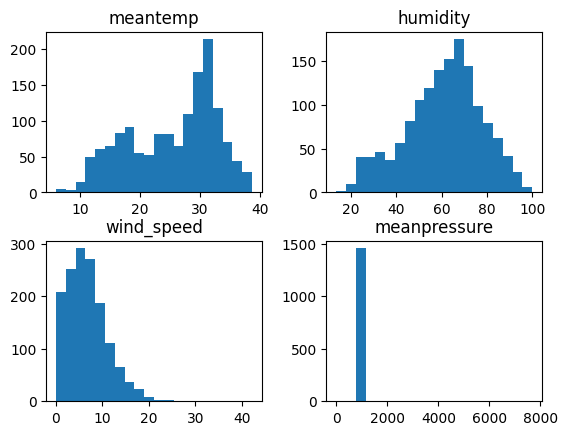

In [6]:
# ------------------------ #
# Quick-and-dirty Insights #
# ------------------------ #

df.hist(bins=20, grid=False);

- __Mean temperature__ (`meantemp`) shows a right-skewed distribution. Most temperate values are concentrated between 20 and 30 with a peak around 30. 
- __Humidty__ (`humidity`) is roughly normal (bell-shaped). The distribution peaks around 60-70%. Most values are concentrated between 40% and 80%. 
- __Wind speed__ (`wind_speed`) is left-skewed. The majority of values are concentrated around 0 and 10.
- __Mean pressure__ (`meanpressure`) shows a highly skewed distribution. The high majority of values is distributed around 1000. There are also high outliers up to values of 8000.

Investigating `meantemp`, `humidity` and `wind_speed` seems to be feasible with classical time-series charts. However, due to the high density of values for `meanpressure` this column needs the removal of outliers to better investigate typical values. 

## ⌚ Behavior Over Time

In [7]:
# ---------------- #
# Helper functions #
# ---------------- #

def plot_time_series_behavior(var, y_label, title):
    # --- Prepare ---

    monthly_avg = df.groupby('month')[var].transform('mean')
    monthly_avg = pd.DataFrame(monthly_avg).reset_index()
    monthly_avg['month'] = monthly_avg[GlobalVars.TIME].dt.to_period('M')

    overall_avg = df[var].mean()
    daily_avg = df[var].resample('D').mean()
    weekly_rolling_avg = daily_avg.rolling(window=7, center=True).mean()

    temp = pd.DataFrame(daily_avg).reset_index()
    temp['month'] = temp[GlobalVars.TIME].dt.to_period('M')
    monthly_avg = pd.merge(left=temp, right=monthly_avg, on=['month'], how='left')
    monthly_avg.rename(columns={
        'date_x': 'date',
        f'{var}_y': f'avg_monthly_{var}'
    }, inplace=True)

    yearly_avg = df.groupby('year')[var].transform('mean')
    yearly_avg = pd.DataFrame(yearly_avg).reset_index()
    yearly_avg['year'] = yearly_avg[GlobalVars.TIME].dt.to_period('Y')


    # --- Visualize ---

    plt.figure(figsize=(8, 4))

    plt.axhline(y=overall_avg, color='grey', alpha=0.5, linestyle='--', label='Overall Average')
    plt.plot(daily_avg, alpha=0.5, lw=0.75, color='C0', label='Daily Average')
    plt.plot(monthly_avg['date'], monthly_avg[f'avg_monthly_{var}'], alpha=0.75, lw=1.0, color='C1', label='Monthly Average')
    plt.plot(yearly_avg['date'][:-1], yearly_avg[var][:-1], alpha=0.75, lw=1.0, color='C2', label='Yearly Average', linestyle='-')

    plt.xlabel('Date')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.15, 0.5), loc='center')
    plt.grid(False)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.show()

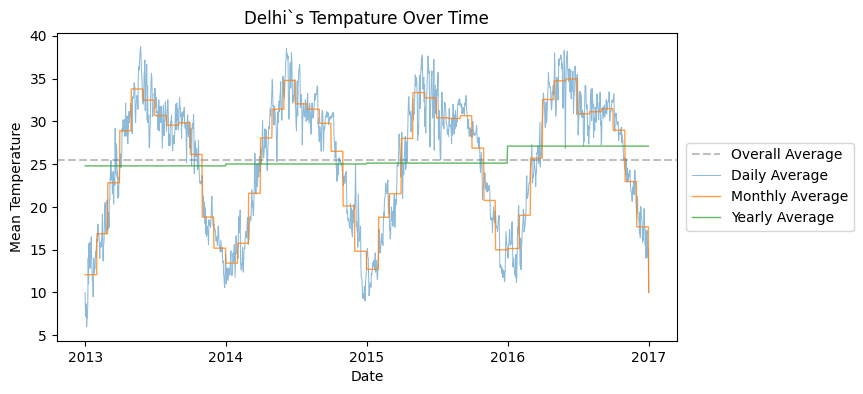

In [8]:
plot_time_series_behavior(GlobalVars.MEAN_TEMPERATURE, 'Mean Temperature', 'Delhi`s Tempature Over Time')

__Seasonal patterns__:
- Delhi's tempature plot shows clear seasonal variations, with temperatures peaking in the summer months (mid-year) and dropping in the winter months (beginning and end of the year). 
- A yearly cycle is evident, with each year showing a similar pattern.

__Overall trend__:
- The yearly averages (green) hover around the over average (dotted grey). However, the yearly average also indicates a slight increase in yearly average tempature, especially observable in the spike from 2016 to 2017.

__Variability__:
- The daily average (blue) shows high variability, reflecting daily tempature fluctuations.
- The monthly average (orange) smooths out these daily fluctuations, making seasonal trends more apparent.
- The yearly average (green) smooths out even more variability, providing a clear picture of long-term trends.

__Summary__: 

> The consistency of the seasonal patterns over the years indicates a stable climate pattern in Delhi during the period from 2013 to 2017. However, a slight yearly upward trend in tempature is showing up.

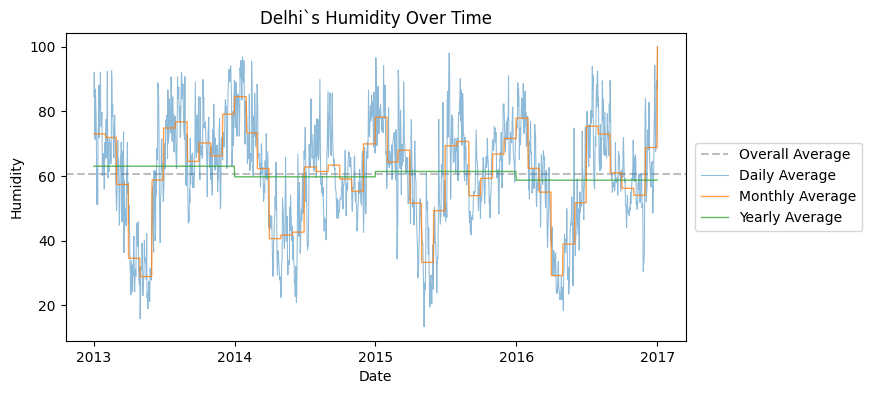

In [9]:
plot_time_series_behavior(GlobalVars.HUMIDITY, 'Humidity', 'Delhi`s Humidity Over Time')

__Seasonal patterns__:
- The plot shows seasonal variations, with periods of higher humidity and periods of lower humidity.
- There are clear fluctuations each year, though not as regular or pronounced as visible in the previous plot's temperature variations.
- Peaks generally occur at different times of the year, indicating periods of increased humidity.

__Overall trend__:
- The yearly averages (green) hover around the over average (dotted grey), indicating no significant long-term trend of increasing or decreasing humidity over the period.

__Variability__:
- The daily average (blue) shows high variability, reflecting daily humidity fluctuations.
- The monthly average (orange) smooths out these daily fluctuations. Seasonal trends are clearly visible even though they are less apparent compared to the tempature plot.

__Summary__: 

> The consistency of the seasonal patterns over the years indicates a stable humidity pattern in Delhi during the period from 2013 to 2017.

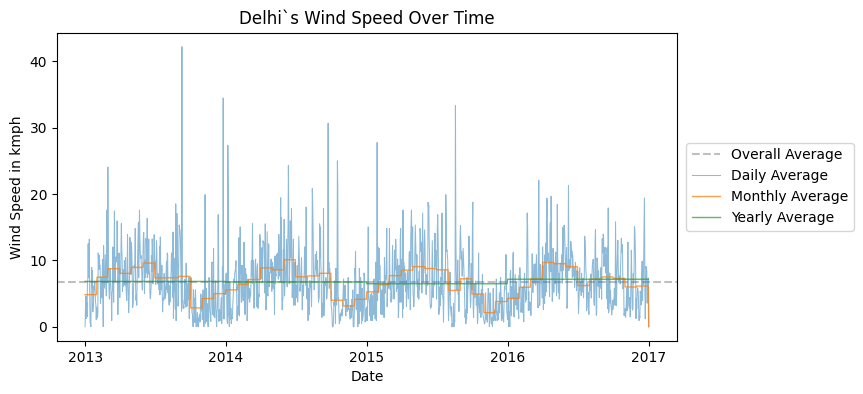

In [10]:
plot_time_series_behavior(GlobalVars.WIND_SPEED, 'Wind Speed in kmph', 'Delhi`s Wind Speed Over Time')

__Seasonal patterns & short-term variability__:
- The plot shows substantial short-term variability, with frequent spikes indicating high wind speed events.
- There are no clear, regular seasonal patterns like those seen in temperature and humidity plots, suggesting that wind speed is influenced by more variable factors.

__Overall trend__:
- The yearly averages (green) hover around the overall average (grey dotted), indicating no significant long-term trend of increasing or decreasing wind speed over the period.

__Variability__:
- The daily average (blue) shows high variability, reflecting daily wind speed fluctuations.
- The monthly average (orange) smooths out these daily fluctuations providing a clearer view of the general trend.
- The yearly average (green) shows a stable trend year-over-year.

__Summary__: 

> There is consistency in the wind speed patterns over the years, with no drastic changes in the trend.

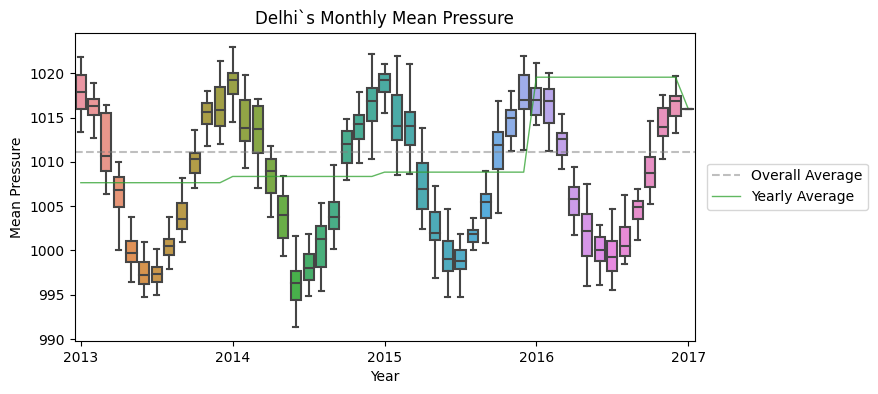

In [11]:
# --- Prepare ---

var = GlobalVars.MEAN_PRESSURE

monthly_avg = df.groupby('month')[var].mean()
monthly_avg = pd.DataFrame(monthly_avg).reset_index()
monthly_avg['month'] = monthly_avg['month'].dt.to_timestamp()
monthly_avg['year'] = monthly_avg['month'].dt.to_period('Y')

overall_avg = df[var].mean()
daily_avg = df[var].resample('D').mean()
weekly_rolling_avg = daily_avg.rolling(window=7, center=True).mean()

yearly_avg = df.groupby('year')[var].mean()
yearly_avg = pd.DataFrame(yearly_avg).reset_index()
yearly_avg['year'] = yearly_avg['year'].astype(str)

temp = pd.DataFrame(monthly_avg).reset_index()
temp['year'] = temp['year'].astype(str)
yearly_avg = pd.merge(left=temp, right=yearly_avg, on=['year'], how='left')
yearly_avg.rename(columns={
    f'{var}_x': f'avg_monthly_{var}',
    f'{var}_y': var
}, inplace=True)
yearly_avg['month'] = yearly_avg['month'].astype(str)


# --- Visualize ---

plt.figure(figsize=(8, 4))

sns.boxplot(data=df, 
            x='month',            
            y=GlobalVars.MEAN_PRESSURE, 
            showfliers=False);
plt.xlabel('Year')
plt.ylabel('Mean Pressure')
plt.title('Delhi`s Monthly Mean Pressure')

ax = plt.gca()
ax.set_xticks(np.arange(0, 12*5, 12))
ax.set_xticklabels(df.index.year.unique())

plt.axhline(y=overall_avg, color='grey', alpha=0.5, linestyle='--', label='Overall Average')
plt.plot(yearly_avg['month'], yearly_avg[var], alpha=0.75, lw=1.0, color='C2', label='Yearly Average', linestyle='-')

plt.legend(bbox_to_anchor=(1.15, 0.5), loc='center')

plt.show()

To better understand the distribution of mean pressure values over time, outliers had to be removed due to the highly skewed distribution. This should allow for a clearer visualization of the central tendency and variability of the data.

__Seasonal patterns__:
- The plot shows clear seasonal variations, with regular cycles of increasing and decreasing mean pressure.
- Typically, there is a dip in mean pressure around the middle of each year, indicating a seasonal low.

__Trends__:
- Each year shows a similar pattern of fluctuations, indicating consistent seasonal effects on mean pressure.

__Variability__:
- The yearly average (green line) shows a relatively stable trend between 2013 to the end of 2015 but a significant increase from end of 2015 to 2017.

__Summary__: 

> There is consistency in the average yearly mean pressure patterns between 2013 up to the end of 2015. The average yearly mean pressure from 2016 is is significantly higher than for the years before.  

# 🧪 Statistical Tests

This section observes the statistical significance of yearly average trends. 

In [12]:
SIGNIFICANCE_LEVEL = 0.05

In [13]:
# --------------------------------- #
# Helper functions for this section #
# --------------------------------- #

def create_custom_colormap(significance_level=SIGNIFICANCE_LEVEL):
    colors = [(0, 'green'), (significance_level, 'green'), (significance_level + 0.00001, 'yellow'), (1, 'brown')]
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
    return cmap

def perform_posthoc_dunn_plot(data, variable, group_col, figsize, significance_level=SIGNIFICANCE_LEVEL):
    print(f"\n{'='*20} {variable} {'='*20}")

    # --- Perform Dunn's test ---
    posthoc = sp.posthoc_dunn(data, 
                              val_col=variable, 
                              group_col=group_col, 
                              p_adjust='bonferroni')
    
    # Create a custom colormap.
    cmap = create_custom_colormap(significance_level)

    # --- Plot the p-value matrix ---
    plt.figure(figsize=figsize)
    sns.heatmap(posthoc, annot=True, fmt=".3f", cmap=cmap, cbar=True,
                linewidths=.5, linecolor='black')
    plt.title(f"Dunn's Test Results for {variable} (p-values)")
    
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    
    plt.show()

In [14]:
# ------------------- #
# Check for normality #
# ------------------- #

for var in GlobalVars.ALL_VARS:
    print(f"{var:<30}")
    stat, p = shapiro(df[var])
    print(f"{4*' '}Statistic={stat}, p-value={p:0.8f}")
    if p > SIGNIFICANCE_LEVEL:
        print(f"{8*' '}Sample looks Gaussian (fail to reject H0)")
    else:
        print(f"{8*' '}Sample does not look Gaussian (reject H0)")

meantemp                      
    Statistic=0.9440180063247681, p-value=0.00000000
        Sample does not look Gaussian (reject H0)
humidity                      
    Statistic=0.984760582447052, p-value=0.00000000
        Sample does not look Gaussian (reject H0)
wind_speed                    
    Statistic=0.9179553985595703, p-value=0.00000000
        Sample does not look Gaussian (reject H0)
meanpressure                  
    Statistic=0.03078937530517578, p-value=0.00000000
        Sample does not look Gaussian (reject H0)


Since non of the distributions is Gaussian, [Kruskal-Wallis test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_test) can be conducted to check for significant differences across years. If any would have been normally, ANOVA could have been performed.


## 📅 Year-over-Year

First, let's compare each year with one another and investigate if their difference is statistically significant.

In [15]:
# ------------------- #
# Kruskal-Wallis Test #
# ------------------- #

significant_vars = []

for var in GlobalVars.ALL_VARS:
    print(f"{20*'='} {var} {20*'='}")
    yearly_avg = df.groupby('year')[var].agg(['mean']).reset_index().rename(columns={'mean': f'avg_{var}'})
    years = yearly_avg['year'].unique()
    grouped_data = [df[df.year == year][var] for year in years]

    # --- Perform Kruskal-Wallis H-test ---

    stat, p = kruskal(*grouped_data)
    print(f"{4*' '}Statistic={stat}, p-value={p:0.8f}")
    if p > SIGNIFICANCE_LEVEL:
        print(f"{8*' '}No significant difference between the yearly means (fail to reject H0)\n")
    else:
        print(f"{8*' '}Significant difference between the yearly means (reject H0)\n")
        significant_vars.append(var)

==================== meantemp ====================
    Statistic=29.37574702289228, p-value=0.00000656
        Significant difference between the yearly means (reject H0)

==================== humidity ====================
    Statistic=25.09441108820536, p-value=0.00004816
        Significant difference between the yearly means (reject H0)

==================== wind_speed ====================
    Statistic=12.823913188144827, p-value=0.01216902
        Significant difference between the yearly means (reject H0)

==================== meanpressure ====================
    Statistic=6.044830340152046, p-value=0.19582524
        No significant difference between the yearly means (fail to reject H0)



To determine which specific years are different from each other, pairwise comparisons can be performed using post-hoc tests. For non-parametric data, [Dunn's test](https://stats.stackexchange.com/tags/dunn-test/info) can be used, which is suitable for multiple comparisons following a Kruskal-Wallis test.


==================== meantemp ====================


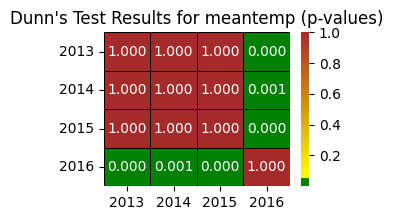


==================== humidity ====================


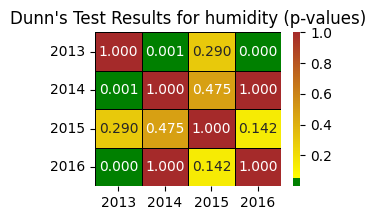


==================== wind_speed ====================


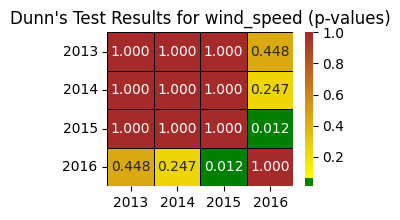

In [16]:
for var in significant_vars:
    perform_posthoc_dunn_plot(df[:-1], var, group_col='year', figsize=(3, 2))

__Mean Temperature (`meantemp`)__:
- The mean temperatures of 2013, 2014 and 2015 are all significantly different from the mean temperature of 2016.

__Humidity (`humidity`)__:
- The humidity of 2013 is significantly different to the humidity of 2014 and 2016.
- The humidity of 2014 is significantly different to the humidity of 2013 and 2016.

__Wind Speed (`wind_speed`)__:
- The wind speed's of 2013, 2014 and 2015 are all significantly different from the wind speed of 2016.

In addition to the yearly comparison it can also be interesting to investigate the month-over-month behavior of the variables. 

## 📅 Month-over-Month

In [17]:
# ------------------- #
# Kruskal-Wallis Test #
# ------------------- #

significant_vars = []

for var in GlobalVars.ALL_VARS:
    print(f"{20*'='} {var} {20*'='}")
    monthly_avg = df.groupby('month')[var].agg(['mean']).reset_index().rename(columns={'mean': f'avg_{var}'})
    months = monthly_avg['month'].unique()
    grouped_data = [df[df.month == month][var] for month in months]

    # --- Perform Kruskal-Wallis H-test ---

    stat, p = kruskal(*grouped_data)
    print(f"{4*' '}Statistic={stat}, p-value={p:0.8f}")
    if p > SIGNIFICANCE_LEVEL:
        print(f"{8*' '}No significant difference between the monthly means (fail to reject H0)\n")
    else:
        print(f"{8*' '}Significant difference between the monthly means (reject H0)\n")
        significant_vars.append(var)

==================== meantemp ====================
    Statistic=1278.264056032857, p-value=0.00000000
        Significant difference between the monthly means (reject H0)

==================== humidity ====================
    Statistic=932.8326761481884, p-value=0.00000000
        Significant difference between the monthly means (reject H0)

==================== wind_speed ====================
    Statistic=392.8737890825106, p-value=0.00000000
        Significant difference between the monthly means (reject H0)

==================== meanpressure ====================
    Statistic=1283.4976188835237, p-value=0.00000000
        Significant difference between the monthly means (reject H0)



There are at least a single significant difference of between two months for each variable. Let's find out from which months these are originating from.


==================== meantemp ====================


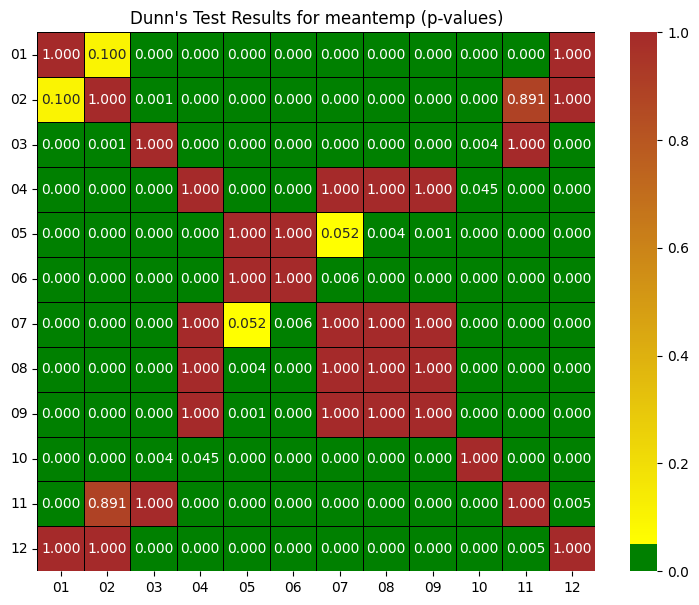


==================== humidity ====================


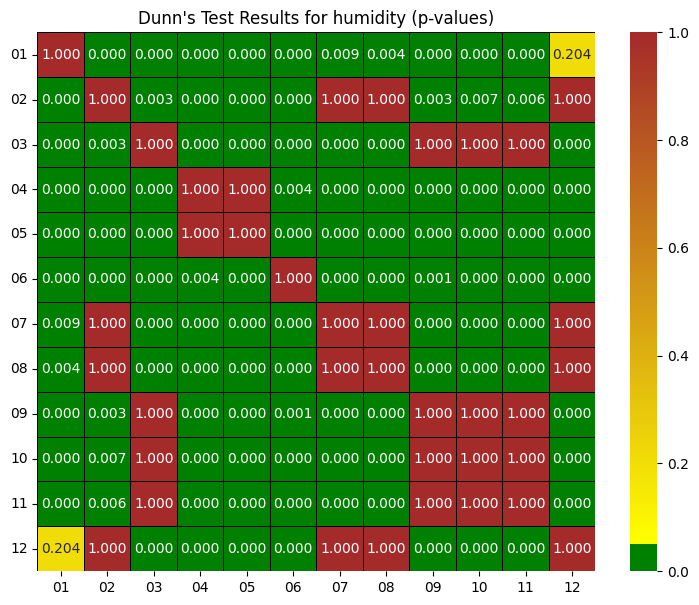


==================== wind_speed ====================


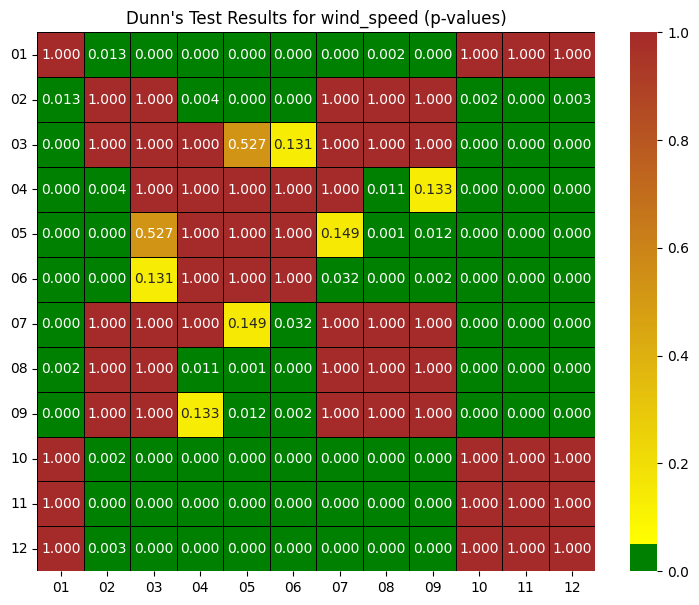


==================== meanpressure ====================


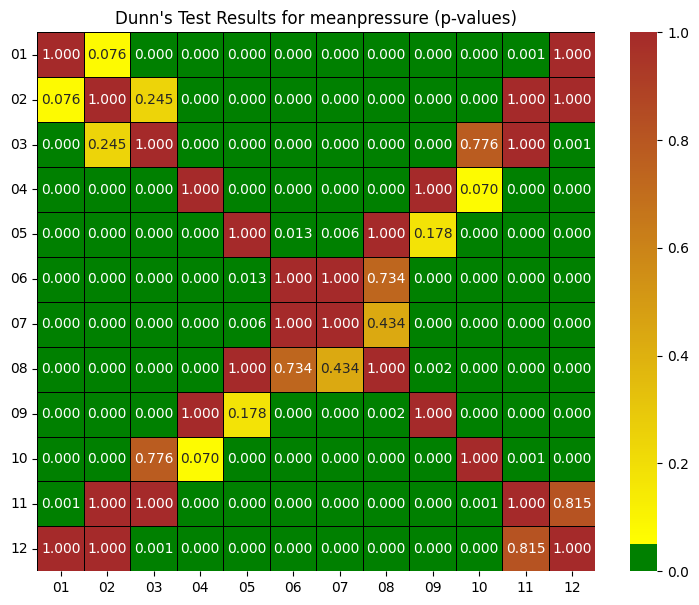

In [18]:
df['month_only'] = df.index.month.astype(str).str.zfill(2)

for var in significant_vars:
    perform_posthoc_dunn_plot(df[:-1], var, group_col='month_only', figsize=(9, 7))

Since there are so many significant differences for this month-over-month comparison it seems to make more sense to investigate rather the month which are _not_ significantly different from one another. This will tell us to understand which months are very similar to each other. Let's think about _not significantly different_ as _very similar to_ in the following. This would mean all month-month tuple with a non-green cell have very similar data.

It would be beyond the scope of this notebook to write down every single comparison. Thus, the following summarizes only the most important insights from the above plots: 

__Mean Temperature (`meantemp`)__:
- Mostly month during the middle of the year are not significantly different (e.g. similar) to each other. This indicates, that summar temperatures are general very similar.

__Humidity (`humidity`)__:
- Humidity is at most similar for three months. 
    - Only one time this is for consectuive months: Sep, Oct, Nov.
- Interestingly, 
    - Feb humidity is similar to Jul, Aug and Dec.
    - Mar humidity is similar to Sep, Oct and Nov.

__Wind Speed (`wind_speed`)__:
- From Mar to Jul monthly week speeds are extremely similar.
- The same holds for the period from Oct to Jan.

__Mean Pressure (`meanpressure`)__:
- Only Jun, Jul and Aug have similar mean pressure. 
- Nov to Dec and Jan to Feb and Mar show no significant different to the chosen significance level of 5%. However, the p-values are sometimes not far from 5%.
- Otherwise, the other months all show a significance between each other.

## 📉 Monotonic Trends

The objective of this section is to test if the data contains monotonic trends, meaning consistently increasing or decreasing or no trend. 

In [19]:
# --------------------------------- #
# Apply the Mann-Kendall trend test #
# --------------------------------- #

for var in GlobalVars.ALL_VARS:
    print(f"\n{'='*20} {var} {'='*20}")
    
    result = mk.original_test(df[var])

    print(f"{4*' '}{result}")
    print(f"{4*' '}Trend is: {result.trend}")


==================== meantemp ====================
    Mann_Kendall_Test(trend='increasing', h=True, p=9.524372835301165e-06, z=4.427698906324337, Tau=0.0772918498376859, s=82547.0, var_s=347564895.6666667, slope=0.0017650158061116989, intercept=26.424941667921118)
    Trend is: increasing

==================== humidity ====================
    Mann_Kendall_Test(trend='decreasing', h=True, p=0.0060123085997942916, z=-2.7471093457315194, Tau=-0.04795546029882274, s=-51216.0, var_s=347570142.0, slope=-0.0029435674201500014, intercept=64.77527600041958)
    Trend is: decreasing

==================== wind_speed ====================
    Mann_Kendall_Test(trend='no trend', h=False, p=0.5102651163411625, z=-0.6584249362844468, Tau=-0.011494478886058028, s=-12276.0, var_s=347560538.0, slope=-0.0001205805566617986, intercept=6.30975076330811)
    Trend is: no trend

==================== meanpressure ====================
    Mann_Kendall_Test(trend='no trend', h=False, p=0.6111040727238477, z=0

- __Mean Temperature__ (`meantemp`) shows a significantly increasing trend.
- __Humidity__ (`humidity`) shows a significantly decreasing trend.
- __Wind Speed__ (`wind_speed`) shows no significant trend.
- __Mean Pressure__ (`meanpressure`) shows no significant trend.

# 🔗 Correlation Analysis

This section aims to understand how correlation the four columns are to each other. 

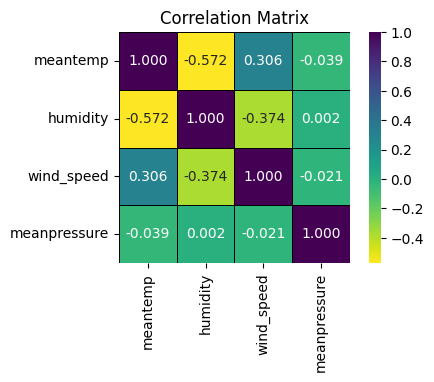

In [20]:
corr_matrix = df[GlobalVars.ALL_VARS].corr()

plt.figure(figsize=(5, 3))

sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='viridis_r', 
            cbar=True, linewidths=0.5, linecolor='black', square=True)
plt.title('Correlation Matrix')

plt.show()

__Mean Temperature (`meantemp`)__:
- Negatively correlated with humidity (-0.572), suggesting higher temperatures are associated with lower humidity.
- Positively correlated with wind speed (0.306), indicating that higher temperatures often come with higher wind speeds.

__Humidty (`humidity`)__:
- Moderately negatively correlated with wind speed (-0.374), indicating that more humid conditions tend to have lower wind speeds.

__Wind Speed (`wind_speed`)__:
- Generally weak correlations with mean pressure (-0.021) and humidity (-0.374), suggesting these relationships are minimal.

__Mean Pressure (`meanpressure`)__:
- Shows very weak correlations with all other variables, indicating it is relatively independent in this dataset.

__Summary__:

> Overall, temperature and humidity have the strongest inverse relationship, while pressure appears to be largely uncorrelated with the other variables.

--- 

💚 Thank you for reading 💚  

If you have any questions or feedback, feel free to leave a comment 🙏